## Setup

In [2]:
import pytorch_lightning
pytorch_lightning.__version__

'1.7.2'

In [ ]:
#RUNNING ON ENVIRONMENT 'UNEXT'
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

from IPython.display import display
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython.display import display
from tqdm.auto import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

In [ ]:
import os
dataset_dir = Path(os.getcwd() + "/DATA/")
images_dir = dataset_dir / 'images'
labels_dir = dataset_dir / 'labels'
image_paths = sorted(images_dir.glob('*.nii'))
label_paths = sorted(labels_dir.glob('*.nii'))
print(len(label_paths))
print(len(image_paths))

assert len(image_paths) == len(label_paths)


import time
modded_subjects = []

for (image_path, label_path) in tqdm((zip(image_paths, label_paths))):
    subject = tio.Subject(
        sample=tio.ScalarImage(image_path),
        label =  tio.LabelMap(label_path)
    )
    # print(subject['label1'].tensor[:,:,:,0].shape)

    modded_subjects.append(subject)
    # time.sleep(0.5)

modded_subjects = modded_subjects*5

dataset = tio.SubjectsDataset(modded_subjects)
print(len(dataset))

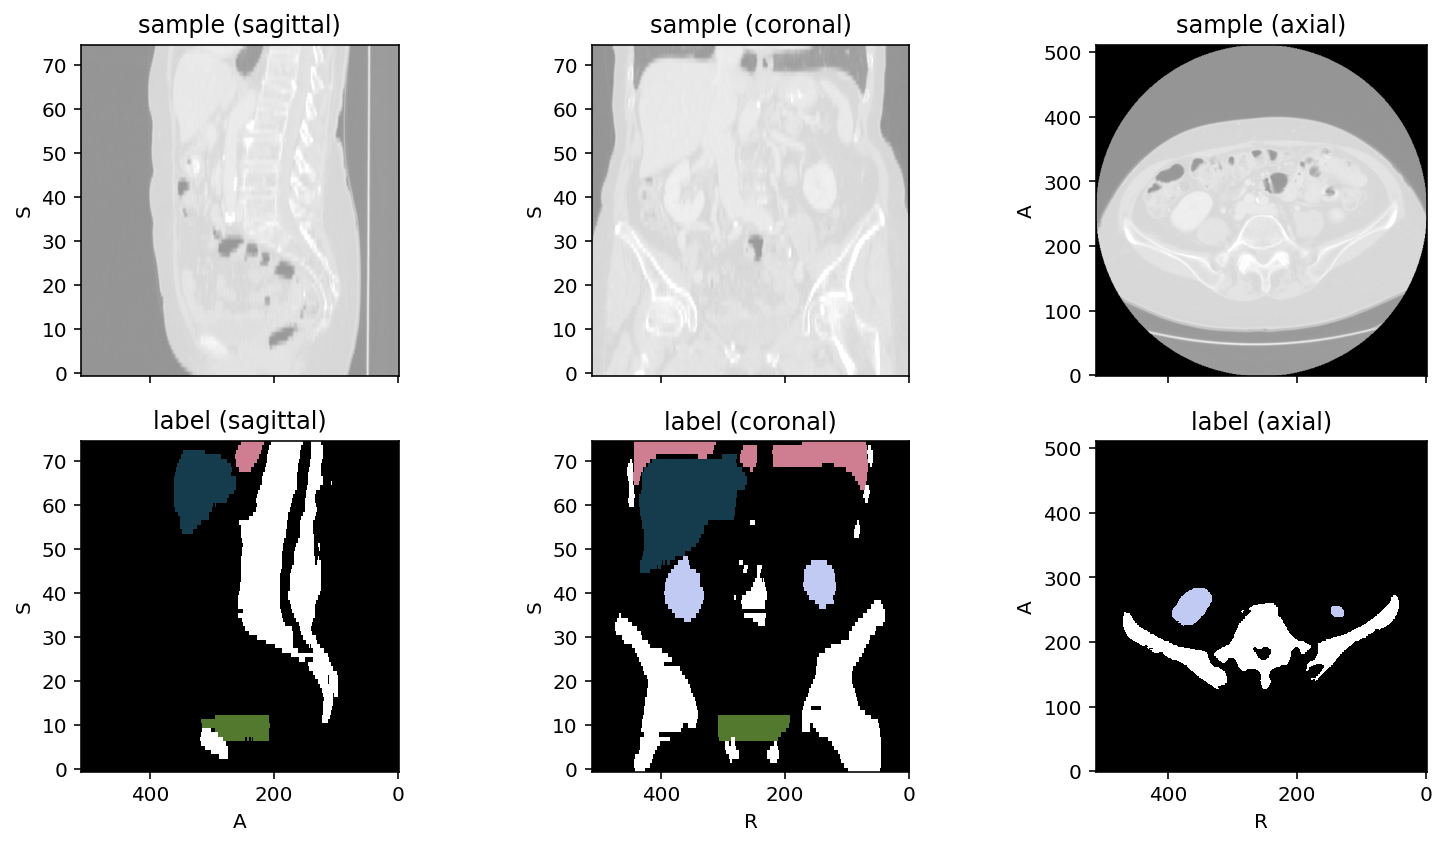

In [161]:
dataset[0].plot()

In [ ]:
mul = 5
shapey = (48, mul*60, mul*48)
RESAMPLE_SPACE = 1 #RETAINS BASE RESOLUTION
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(RESAMPLE_SPACE),
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.CropOrPad(shapey), #should this be after the flip?
    tio.RescaleIntensity((0,1)),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(RESAMPLE_SPACE),
    tio.CropOrPad(shapey),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])


dataset = tio.SubjectsDataset(modded_subjects) #can multiply size because of augmentation

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
print(num_split_subjects)
training_subjects, validation_subjects = torch.utils.data.random_split(modded_subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

training_set_raw = [] 
val_set_raw = []

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

### Lightning Converted Functions

In [ ]:
import pytorch_lightning as pl
import os
import time
DATA_PATH = Path(os.getcwd() + "/DATA/")

In [ ]:
#non class functions

import cv2
import numpy as np
  
import torchvision.transforms.functional as Ft

def prepare_batch(batch):
    inputs = batch['sample'][tio.DATA]
    targets = batch['label'][tio.DATA]
    return inputs, targets
def get_dice_score(output, target, epsilon=1e-9):
    # print(f"Output: {type(output)}, {output.shape}")
    # print(f"Target: {type(target)}, {output.shape}")
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    loss = 1 - get_dice_score(output, target)
    if type(loss) is None:
        return -1
    # print(f"LOSS TYPE: {type(loss)}")
    return loss






In [155]:
RESAMPLE = 1 #4
class CATDataModule(pl.LightningDataModule):
    def __init__(self, train_batch_size, val_batch_size):
        super().__init__()
        image_mul = 4
        self.image_shape = (48, image_mul*60, image_mul*48)
        self.training_subjects = []
        self.validation_subjects = []
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.dataset = []
        self.num_workers = 8
        self.training_split_ratio = 0.9

    def prepare_data(self):
        dataset_dir = Path(os.getcwd() + "/ALL_DATA/gzorg/")
        images_dir = dataset_dir / 'images'
        labels_dir = dataset_dir / 'labels'
        image_paths = sorted(images_dir.glob('*.nii.gz'))
        label_paths = sorted(labels_dir.glob('*.nii.gz'))

        assert len(image_paths) == len(label_paths)
        self.dataset = []
        for (image_path, label_path) in tqdm(zip(image_paths, label_paths), total=len(image_paths)):
            subject = tio.Subject(
                sample=tio.ScalarImage(image_path),
                label =  tio.LabelMap(label_path))
            self.dataset.append(subject)
            # time.sleep(0.1)
        # print(len(self.dataset))

    def setup(self, stage):

        num_training_subjects = int(self.training_split_ratio * len(self.dataset))
        num_validation_subjects = len(self.dataset) - num_training_subjects
        num_split_subjects = [num_training_subjects, num_validation_subjects]
        #WHY IS THIS NUMBER WRONG?
        self.training_subjects, self.validation_subjects = torch.utils.data.random_split(self.dataset, num_split_subjects)
    
    def train_dataloader(self):
        training_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(RESAMPLE),
                    tio.CropOrPad(self.image_shape),
                    tio.RandomMotion(p=0.2),
                    tio.RandomBiasField(p=0.3),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.RescaleIntensity([0,1]),
                    tio.RandomNoise(p=0.5),
                    tio.RandomFlip(),
                    tio.OneOf({
                        tio.RandomAffine(): 0.8,
                        tio.RandomElasticDeformation(): 0.2,
                    }),
                    tio.OneHot(),
                    tio.RescaleIntensity((0,1))])

        validation_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(RESAMPLE),
                    tio.CropOrPad(self.image_shape),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.OneHot(),
                    tio.RescaleIntensity((0,1))
                ])
        training_set = tio.SubjectsDataset(
                            training_subjects, transform=training_transform)

        training_loader = torch.utils.data.DataLoader(
                            training_set,
                            batch_size=self.train_batch_size,
                            shuffle=True,
                            num_workers=self.num_workers)
        return training_loader

    def val_dataloader(self):
        validation_transform = tio.Compose([
                    tio.ToCanonical(),
                    tio.Resample(RESAMPLE),
                    tio.CropOrPad(self.image_shape),
                    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
                    tio.OneHot(),
                    tio.RescaleIntensity((0,1))
                ])
        validation_set = tio.SubjectsDataset(
                        validation_subjects, transform=validation_transform)
      
        validation_loader = torch.utils.data.DataLoader(
                        validation_set,
                        batch_size=self.val_batch_size,
                        shuffle=False,
                        num_workers=self.num_workers)
        return validation_loader

In [ ]:
import wandb
# wandb.init(project="3dUnet")
wandb.config = {
    #Model Parameters
  "num_encoding_blocks":3,
  "out_channels_first_layer":8,
  "activation": "PReLU",
    #Training Parameters
  "learning_rate": 0.001,
  "epochs": 10,
  "train_batch_size": 4,
  "val_batch_size":4
}


In [6]:
print(unet.__file__)

e:\Applications\Anaconda\envs\swamphacks\lib\site-packages\unet\__init__.py


In [5]:
import unet

In [ ]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(
        in_channels=1,
        out_classes=6,
        dimensions=3,
        num_encoding_blocks=wandb.config['num_encoding_blocks'],
        out_channels_first_layer=wandb.config['out_channels_first_layer'],
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation=wandb.config['activation'])
    def forward(self, x):
        return self.model(x)
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=wandb.config['learning_rate'])
        return optimizer
    def training_step(self, train_batch, batch_index):
        inputs = train_batch['sample'][tio.DATA]
        targets = train_batch['label'][tio.DATA]
        with torch.enable_grad():
            logits = self.model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets.short())
            batch_loss = batch_losses.mean()
        self.log('train_loss', batch_loss.item())
        return {'loss': batch_loss}
   
    def validation_step(self, val_batch, batch_index):
        inputs, targets = prepare_batch(val_batch)
        with torch.no_grad():
            logits = self.model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets.short())
            batch_loss = batch_losses.mean()
        self.log('val_loss', batch_loss.item())
        return {'loss': batch_loss}
    
    def predict_step(self, batch, batch_idx, datloader_idx=0):
        prediction = self(batch)
        return prediction
    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()
    # def optimizer_step(self,epoch=None, batch_idx=None, optimizer=None, optimizer_idx=None, optimizer_closure=None, on_tpu=None, using_native_amp=None, using_lbfgs=None):
    #     optimizer.step()
    #     optimizer.closure()

        



In [156]:
datamodule = CATDataModule(4,4)
datamodule.prepare_data()
datamodule.setup(0)
model = Segmenter()
trainer = pl.Trainer( fast_dev_run=False)
trainer.tune(model, datamodule=datamodule)
trainer.fit(model, datamodule=datamodule)

0it [00:00, ?it/s]


In [145]:
def tensor_to_video(inputs, name="TEST", mode='L'):
  slices = []
  # print(inputs.size())
  for i in range(inputs.size()[2]):
      slice = inputs[0, :,i,:,:];img = Ft.to_pil_image(slice, mode=mode)
      # print(slice.size())
      slices.append(img)
  fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
  video = cv2.VideoWriter(f'{name}.mp4', fourcc, inputs.size()[2], (inputs.size()[4]  , inputs.size()[3]))

  for j in slices:
    j = np.array(j)
    shape = np.shape(j)
    opencvImage = cv2.cvtColor(j,cv2.COLOR_GRAY2BGR)
    video.write(opencvImage)

  cv2.destroyAllWindows()
  video.release()

In [160]:
inputs1 = (sub['sample'][tio.DATA])
tensor_to_video(inputs1,name='t', mode='L')

In [ ]:
n = inputs.numpy()
# n = n[:,:,0,0,0]
print(np.shape(n))
print(n[:,0])